In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm import tqdm
from sklearn import linear_model
import pandas as pd
from math import sqrt
import math


Object 1 range: 34- 90, object 3 range: 241 - 391

In [2]:
WHEEL_BASE = 2.43 #IN METERS
MPERSTOMPH = 2.237  # METERS PER SECOND TO MILES PER HOUR
FRAMESTOSEC = 0.033
DISTANCE_ERROR_THRESHOLD = 3
INBETWEENANGLE = 45


In [3]:
annotation_dir = '/root/.darwin/datasets/sparrow-computing/speed_eval/releases/v2/annotations'
annotations_list = os.listdir(annotation_dir)

In [4]:
def get_theta(_x1, _y1, _x2, _y2):
    return 90 - math.degrees(math.atan((_y2 - _y1)/(_x2 - _x1)))

In [5]:
def get_distance(x1, y1, x2, y2):
    return math.sqrt((x1-x2)**2 + (y1 -y2)**2)

In [6]:
def frames_to_seconds(_fps, _n_frames):
    return (1/_fps) * _n_frames

In [7]:
front_tire_x_list = []
front_tire_y_list = []
back_tire_x_list = []
back_tire_y_list = []
object_start = 241
object_end = 391
for i in range(object_start, object_end):
    f = open(os.path.join(annotation_dir, f'{i}.json'))
    tires = json.load(f)
    if len(tires['annotations'])== 2:
        back_x = tires['annotations'][0]['keypoint']['x']
        back_y = tires['annotations'][0]['keypoint']['y']
        front_x = tires['annotations'][1]['keypoint']['x']
        front_y = tires['annotations'][1]['keypoint']['y']
        #
        front_tire_x_list.append(front_x)
        front_tire_y_list.append(front_y)
        back_tire_x_list.append(back_x)
        back_tire_y_list.append(back_y)
    if len(tires['annotations'])== 1:
        back_x = tires['annotations'][0]['keypoint']['x']
        back_y = tires['annotations'][0]['keypoint']['y']
        front_x = -1
        front_y = -1
        #
        front_tire_x_list.append(front_x)
        front_tire_y_list.append(front_y)
        back_tire_x_list.append(back_x)
        back_tire_y_list.append(back_y)
total_num_points = len(front_tire_x_list)

In [8]:
distance_between_each_frame = []
for i in range(len(back_tire_x_list)-1):
    back_x = back_tire_x_list[i]
    back_y = back_tire_y_list[i]
    future_back_x = back_tire_x_list[ i + 1]
    future_back_y = back_tire_y_list[ i + 1]
    distance_between_each_frame.append(get_distance(back_x, back_y, front_x, front_y))

Text(0, 0.5, 'Distance back tire has traveled')

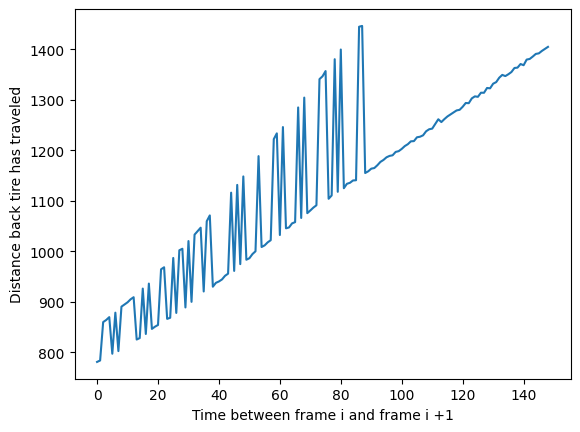

In [23]:
plt.plot(distance_between_each_frame)
plt.xlabel("Time between frame i and frame i +1")
plt.ylabel('Distance back tire has traveled')
# plt.plot([28 for i in range(800, 1400)], list(range(800, 1400)))
# plt.plot([29 for i in range(800, 1400)], list(range(800, 1400)))

In [10]:
data = {"back_tire_x":back_tire_x_list, "back_tire_y":back_tire_y_list, "front_tire_x":front_tire_x_list, "front_tire_y":front_tire_y_list}
df = pd.DataFrame(data)
df.drop(df[df.back_tire_x < 0].index, inplace=True)
df.drop(df[df.front_tire_x < 0].index, inplace=True)
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [11]:
#
model = linear_model.LinearRegression()
model.fit(x, y)
coef = model.coef_[0]
bias = model.intercept_
coef = [
    i + 0.0000001 if i == 0 else i for i in coef
]  # Add a small value to avoid division by zero.
#

In [12]:
back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
for i in range(len(data['back_tire_x'])):
    back_tire_x = data['back_tire_x'][i]
    back_tire_y = data['back_tire_y'][i]
    front_tire_x = data['front_tire_x'][i]
    front_tire_y = data['front_tire_y'][i]
    if (back_tire_x < 0 and back_tire_y < 0) and (front_tire_x < 0 and front_tire_y < 0):
        back_tire_x_list.append(back_tire_x)
        back_tire_y_list.append(back_tire_y)
        front_tire_x_list.append(front_tire_x)
        front_tire_y_list.append(front_tire_y)
        continue
    if back_tire_x < 0:
        back_tire_x = (front_tire_y - back_tire_y * coef[1] - front_tire_x* coef[2] - bias)/coef[0]
    if back_tire_y < 0:
        back_tire_y = (front_tire_y - back_tire_x * coef[0] - front_tire_x* coef[2] - bias)/coef[1]
    if front_tire_x < 0:
        front_tire_x = (front_tire_y - back_tire_x * coef[0] - back_tire_y * coef[1] - bias)/coef[2]
    if front_tire_y < 0:
        front_tire_y = back_tire_x * coef[0] + back_tire_y * coef[1] + front_tire_x* coef[2] + bias

    back_tire_x_list.append(back_tire_x)
    back_tire_y_list.append(back_tire_y)
    front_tire_x_list.append(front_tire_x)
    front_tire_y_list.append(front_tire_y)

In [13]:

vehicle_speed = []
skipped = 0

back_tire_keypoints = [back_tire_x_list, back_tire_y_list]
back_tire_keypoints = [list(x) for x in zip(*back_tire_keypoints[::-1])]
front_tire_keypoints = [front_tire_x_list, front_tire_y_list]
front_tire_keypoints = [list(x) for x in zip(*front_tire_keypoints[::-1])]

back_tire_x_list = []
back_tire_y_list = []
front_tire_x_list = []
front_tire_y_list = []
speed_checkpoints = []

approximate_speed = -1
vehicle_speed = {}
for i in range(total_num_points):
    back_tire = back_tire_keypoints[i]
    front_tire = front_tire_keypoints[i]
    if back_tire[0] < 0 or front_tire[0] <0:
        vehicle_speed[i] = approximate_speed
        skipped+=1
        continue
    for j in range(i,total_num_points):
        future_back_tire = back_tire_keypoints[j]
        if future_back_tire[0] < 0:
            continue
        back_tire_x = back_tire[0]
        back_tire_y = back_tire[1]
        front_tire_x = front_tire[0]
        front_tire_y = front_tire[1]
        future_back_tire_x = future_back_tire[0]
        future_back_tire_y = future_back_tire[1]
        current_keypoints_distance = get_distance(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
        future_keypoints_distance = get_distance(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
        
        # try:
        #     theta = get_theta(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
        #     print("Aragon says", theta)
        # except:
        #     pass
        # if  current_keypoints_distance <= future_keypoints_distance:
        if  (current_keypoints_distance - future_keypoints_distance) >= -DISTANCE_ERROR_THRESHOLD and (current_keypoints_distance - future_keypoints_distance) <= DISTANCE_ERROR_THRESHOLD:
            alpha = get_theta(back_tire_x, back_tire_y, future_back_tire_x, future_back_tire_y)
            beta = get_theta(back_tire_x, back_tire_y, front_tire_x, front_tire_y)
            # print("Ado", future_keypoints_distance - current_keypoints_distance, INBETWEENANGLE>=alpha + beta)
            # if (future_keypoints_distance - current_keypoints_distance) < DISTANCE_ERROR_THRESHOLD and INBETWEENANGLE>=alpha + beta:
            if  INBETWEENANGLE>=alpha + beta:
                approximate_speed = round(WHEEL_BASE / frames_to_seconds(30, j + 1 - i))
                print("Current Speed is", approximate_speed * MPERSTOMPH, "mph",  back_tire_x,back_tire_y, future_back_tire_x, future_back_tire_y,i, j)
                vehicle_speed[i] = round(approximate_speed* MPERSTOMPH)
                back_tire_x_list.append(back_tire_x)
                back_tire_y_list.append(back_tire_y)
                front_tire_x_list.append(front_tire_x)
                front_tire_y_list.append(front_tire_y)
            break
        
    



Current Speed is 8.948 mph 480.22 613.97 500.87 685.78 0 19
Current Speed is 8.948 mph 480.22 617.56 500.87 685.78 1 19
Current Speed is 11.185 mph 505.36 693.86 526.9 771.95 2 17
Current Speed is 11.185 mph 506.26 698.35 526.9 771.95 3 17
Current Speed is 4.474 mph 507.15 704.63 533.18 786.31 4 42
Current Speed is 80.53200000000001 mph 509.85 713.6 487.41 635.51 6 7
Current Speed is 8.948 mph 487.41 635.51 508.95 713.6 7 26
Current Speed is 11.185 mph 515.23 724.38 536.77 804.26 8 22
Current Speed is 4.474 mph 515.23 729.76 542.16 818.63 9 49
Current Speed is 11.185 mph 516.13 734.25 543.06 822.22 10 25
Current Speed is 4.474 mph 518.82 739.64 547.55 828.5 11 51
Current Speed is 11.185 mph 519.72 744.12 547.55 837.48 12 27
Current Speed is 6.711 mph 494.59 662.44 521.51 756.69 14 35
Current Speed is 80.53200000000001 mph 525.11 761.18 497.28 670.52 15 16
Current Speed is 6.711 mph 497.28 670.52 525.11 765.67 16 38
Current Speed is 11.185 mph 526.9 771.95 557.42 867.99 17 32
Current Sp

In [14]:
n_checkpoints = int(len(vehicle_speed))

In [15]:
avg_speed = np.array(list(vehicle_speed.values())).sum()/n_checkpoints

In [16]:
f= open('/code/data/datasets/tracking/predictions/25_resampled_vid/speed_log.json')
speed_log = json.load(f)

In [17]:
algo_preds = speed_log["1"].values()

In [18]:
algo_preds = [ i for i in algo_preds if i > 0]

In [19]:
predicted_avg_speed = np.array(algo_preds).sum()/ len(algo_preds)

In [20]:
print("Error percentage:" , abs(avg_speed - predicted_avg_speed)/ avg_speed, "%")

Error percentage: 0.5243856468434185 %
